In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [241]:
class sghmc():
    def __init__(self,data,lnp_grad,initial,C,B=0,M=None,logpri=None):
        '''
        
        '''
        self.get_data(data)
        self.get_mass_matrix(M)
        self.get_fric_term(B,C)
        self.theta0 = initial
        self.lnp_grad = lnp_grad
        if logpri is None:
            self.logpri = self.gauss_logL
        else:
            self.logpri = logpri
        
    def gauss_logL(self,theta=None,mu=None,sigma=None):
        """
        gaussian likelihood function
        """
        k = self.ndim
        if mu is None:
            mu = np.zeros(k)
        if sigma is None:
            sigma = np.identity(k)
        return -0.5*(np.log(sigma) + (theta-mu).T @ np.linalg.inv(sigma) @ (theta-mu) + k*np.log(2*np.pi))
    
    def get_data(self, data):
        """
        get the dataset with the frame of [n_observation * n_features]
        """
        self.data = data
        self.ndim = len(data[0])
        
    def get_mass_matrix(self, mass_matrix=None):
        """
        get the inverse of the mass matrix
        """
        if mass_matrix is None:
            self.mass_matrix = np.identity(self.ndim)
            self.inverse_mass_matrix = np.identity(self.ndim)
        else:
            if len(mass_matrix) != self.ndim:
                print("Invalid mass matrix")
            elif len(mass_matrix) == 1:
                self.mass_matrix = mass_matrix
                self.inverse_mass_matrix = 1. / mass_matrix
                #self.ndim_mass = 1
            else:
                self.mass_matrix = mass_matrix
                self.inverse_mass_matrix = np.linalg.inv(mass_matrix)
            #self.ndim_mass = 2
        
    def get_fric_term(self, B_est=0, C=None):
        """
        define variance of noise model and user specified friction term
        """
        self.B = B_est
        self.C = C
        
    def define_momentum(self):
        """
        sample momentum
        """
        if self.ndim == 1:
            r = np.random.normal(0, np.sqrt(self.mass_matrix))
        else:
            r = np.random.multivariate_normal(np.zeros(self.ndim), self.mass_matrix)
        return r
    
    def velocity(self, r):
        """
        Get the velocities (gradient of kinetic) given a momentum vector
        """
        if self.ndim == 1:
            v = self.inverse_mass_matrix * r
        else:
            v = np.dot(self.inverse_mass_matrix, r)
        return v

    #def kinetic_energy(self, r):
    #    """
    #    Get the kinetic energy given momentum
    #    """
    #    if self.ndim == 1:
    #        K = self.inverse_mass_matrix * r**2
    #    else:
    #        K = np.dot(r.T, np.dot(self.inverse_mass_matrix, r))
    #    return 0.5 * K
    
    def leapfrog(self, theta, r, epsilon, size):
        """Perfrom one leapfrog step, updating the momentum and position
        vectors. 
        """
        #update momentum and position vectors
        theta += epsilon * self.velocity(r)
        r1 = - 0.5 * epsilon * self.grad_U(size, theta)
        
        if self.ndim == 1:
            r2 = - epsilon * self.C * self.velocity(r)
            r3 = np.random.normal(np.zeros(self.ndim), 2*epsilon*(self.C-self.B))
        else:
            r2 = - epsilon * self.C @ self.velocity(r)
            r3 = np.random.multivariate_normal(np.zeros(self.ndim), 2*epsilon*(self.C-self.B))
        r = r + r1 + r2 + r3
        #r = r - 0.5 * epsilon * self.grad_U(size, theta) - epsilon * self.C @ self.velocity(r) + np.random.multivariate_normal(np.zeros(self.ndim), 2*epsilon*(self.C-self.B))
        return theta, r
    
    #def lnprob(self, theta, x):#。。。
    #    return self.model.lnprob(theta, x)
        
    #def lnprob_grad(self, theta):#。。。
    #    return self.model.lnprob_grad(theta)
    
    def grad_U(self, size, theta):
        """
        get the estimate gradient based on minibatches
        
        pramas size:
            number of datapoints
        """
        df = pd.DataFrame(self.data)
        batch = df.sample(n=size)#,random_state=np.random.RandomState())
        s = 0
        for x in batch:
            s += self.lnp_grad(x, theta)
        u = -self.ndim/size * s - self.logpri_grad(theta)
        
        return u
    
    def sampling(self, iterations, epsilon, length, size):
        """
        sample theta for distribution
        
        pramas theta0:
            initial value 
        
        pramas iterations:
            number of sampling (trajectory)
        
        params epsilon:
            stepsize for the leapfrog
        
        params length:
            number of leapfrog
            
        params size:
            the size of minibatches
        """
        #setup sampling storage
        self.samples = np.zeros([iterations, self.ndim])
        
        theta0 = self.theta0
        
        # loop over trajectories
        for t in range(iterations):
            r = self.define_momentum()
            theta = theta0
            self.samples[t, :] = theta
            
            #loop over leapfrog
            theta_t, r_t = theta, r 
            for i in range(length):
                theta_m, r_m = self.leapfrog(theta_t, r_t, epsilon, size)
                theta_t,r_t = theta_m, r_m
            theta0 = theta_m 

In [242]:
temp = sghmc(a,g_grad,5,1)

In [253]:
temp.sampling(2000,0.001,100,100)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in matmul
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in subtract


In [254]:
temp.samples

array([[5.        ],
       [4.89809574],
       [4.86518502],
       ...,
       [       nan],
       [       nan],
       [       nan]])

In [252]:
sum(temp.samples)/len(temp.samples)

array([4.48061539])

In [193]:
sum(temp.samples)/len(temp.samples)

array([2.36604422])

In [3]:
def gauss_logL(x, sigma, mu):
    """gaussian likelihood"""
    k = len(x)
    return -0.5*(np.log(sigma) + (x-mu).T @ sigma**(-1) @ (x-mu) + k*np.log(2*np.pi))

In [11]:
np.random.multivariate_normal(np.zeros(10), np.identity(10))

array([-0.07846585, -1.60963502,  0.08495507, -0.40429658,  1.13788322,
       -1.48662331,  1.68213795,  0.05533619,  0.2492001 ,  0.56353529])

In [106]:
a = np.random.normal(loc=2.5,scale=1,size=10000)
a = a.reshape([-1,1])

In [13]:
def g_grad(x,theta):
    return (x-theta)/1

In [ ]:
d = len(initial)
for i in range(d):
    r[i] = ...
M
samples: df/dic/[k,m,n]


In [516]:
class hmc():
    def __init__(self,data,lnp,lnp_grad,initial,M=None,logpri=None):
        '''
        
        '''
        self.get_data(data)
        self.get_mass_matrix(M)
        self.theta0 = initial
        self.lnp = lnp
        self.lnp_grad = lnp_grad
        self.res = []
        self.n = len(data)
 
    def get_data(self, data):
        """
        get the dataset with the frame of [n_observation * n_features]
        """
        self.data = data
        self.ndim = len(data[0])
        
    def get_mass_matrix(self, mass_matrix=None):
        """
        get the inverse of the mass matrix
        """
        if mass_matrix is None:
            self.mass_matrix = np.identity(self.ndim)
            self.inverse_mass_matrix = np.identity(self.ndim)
        else:
            if len(mass_matrix) != self.ndim:
                print("Invalid mass matrix")
            elif len(mass_matrix) == 1:
                self.mass_matrix = mass_matrix
                self.inverse_mass_matrix = 1. / mass_matrix
                #self.ndim_mass = 1
            else:
                self.mass_matrix = mass_matrix
                self.inverse_mass_matrix = np.linalg.inv(mass_matrix)
            #self.ndim_mass = 2
        
    def define_momentum(self):
        """
        sample momentum
        """
        if self.ndim == 1:
            r = np.random.normal(0, np.sqrt(self.mass_matrix))
        else:
            r = np.random.multivariate_normal(np.zeros(self.ndim), self.mass_matrix)
        return r
    
    def velocity(self, r):
        """
        Get the velocities (gradient of kinetic) given a momentum vector
        """
        if self.ndim == 1:
            v = self.inverse_mass_matrix * r
        else:
            v = np.dot(self.inverse_mass_matrix, r)
        return v

    def kinetic_energy(self, r):
        """
        Get the kinetic energy given momentum
        """
        if self.ndim == 1:
            K = self.inverse_mass_matrix * r**2
        else:
            K = np.dot(r.T, np.dot(self.inverse_mass_matrix, r))
        return 0.5 * K
    
    def grad_U(self, theta):
        """
        get the estimate gradient based on minibatches
        
        pramas size:
            number of datapoints
        """
        df = pd.DataFrame(self.data)
        s = 0
        for x in df:
            s += self.lnp_grad(x, theta)      
        return s / self.n
    
    def leapfrog(self, theta, r, epsilon):
        """Perfrom one leapfrog step, updating the momentum and position
        vectors. 
        """
        #update momentum and position vectors
        theta += epsilon * self.velocity(r)
        r -= epsilon * self.grad_U(theta)
        #r = r - 0.5 * epsilon * self.grad_U(size, theta) - epsilon * self.C @ self.velocity(r) + np.random.multivariate_normal(np.zeros(self.ndim), 2*epsilon*(self.C-self.B))
        return theta, r
    
    
    
    def trajectory(self, theta_t, epsilon,length):
        r_t = self.define_momentum()
        theta0, r0 = theta_t, r_t
        r0 = r_t-0.5*epsilon*self.grad_U(theta0)
        for i in range(length):
            theta_m, r_m = self.leapfrog(theta0,r0,epsilon)
            theta0, r0 = theta_m, r_m
        r0 -= 0.5*epsilon*self.grad_U(theta0)
        
        
        #M-H step
        mu = np.random.uniform(size=1)
        p = np.exp(self.U(theta0)+self.kinetic_energy(r0) - self.U(theta_t) - self.kinetic_energy(r_t))
        print(p)
        
        if mu < min(1,p):
            return theta0
        else:
            return 0 
    
    def U(self, theta):
        
        df = pd.DataFrame(self.data)
        s = 0
        for x in df:
            s += self.lnp(x, theta)
        
        return -s/self.n
    
    
    def sampling(self, iterations, epsilon, length, size):
        """
        sample theta for distribution
        
        pramas theta0:
            initial value 
        
        pramas iterations:
            number of sampling (trajectory)
        
        params epsilon:
            stepsize for the leapfrog
        
        params length:
            number of leapfrog
            
        params size:
            the size of minibatches
        """
        #setup sampling storage
        self.samples = np.zeros([iterations, self.ndim])
        thetacurr = self.theta0
        # loop over trajectories
        for t in range(iterations):
            temp = self.trajectory(thetacurr, epsilon, length)
            if temp != 0:
                self.res.append(temp[0][0])
                thetacurr = temp

In [6]:
a = np.random.normal(loc=2.5,scale=1,size=1000)
a = a.reshape([-1,1])

In [506]:
def gauss_logL(x, sigma, mu):
    """gaussian likelihood"""
    k = len(x)
    return -0.5*(np.log(sigma) + (x-mu).T @ sigma**(-1) @ (x-mu) + k*np.log(2*np.pi))

In [2]:
def g_grad(x,theta):
    return (x-theta)

In [3]:
def logl(x, mu):
    return -0.5 * np.log(2*np.pi) - (((x-mu) ** 2) / 2)

In [519]:
temp = hmc(a,logl,g_grad,5)

In [520]:
temp.sampling(5000,0.2,10,500)

[[1.00167367]]
[[0.99993478]]
[[1.00140955]]
[[0.99808293]]
[[1.00170947]]
[[0.99987242]]
[[1.00056299]]
[[1.00031346]]
[[0.99910557]]
[[1.00041236]]
[[1.00049432]]
[[0.99740279]]
[[1.00271347]]
[[0.99861633]]
[[0.99986737]]
[[1.0044612]]
[[0.99831256]]
[[1.00475893]]
[[1.00569]]
[[0.99603551]]
[[1.0004421]]
[[0.99919532]]
[[0.99751321]]
[[0.99830738]]
[[1.00137095]]
[[1.00303099]]
[[0.99844105]]
[[1.00229092]]
[[1.00141821]]
[[1.00031733]]
[[1.00038378]]
[[0.9953277]]
[[1.00139931]]
[[1.00230898]]
[[1.00158926]]
[[1.00181278]]
[[0.99853288]]
[[1.0029939]]
[[0.99885294]]
[[1.00487886]]
[[1.00162895]]
[[0.99629997]]
[[1.00268982]]
[[1.0065015]]
[[0.99579026]]
[[0.99798552]]
[[0.99844497]]
[[1.00241699]]
[[0.99658891]]
[[1.00026071]]
[[0.99948753]]
[[1.00423582]]
[[0.9975259]]
[[0.99962656]]
[[1.00825994]]
[[0.99546401]]
[[1.00410039]]
[[1.00423229]]
[[1.00699907]]
[[1.00868265]]
[[1.00473952]]
[[0.99598301]]
[[0.99681163]]
[[1.00801597]]
[[0.99285327]]
[[0.99603987]]
[[0.99503658]]
[[0.

[[1.0162797]]
[[0.97786046]]
[[1.00482492]]
[[1.02153607]]
[[1.01237183]]
[[1.00021537]]
[[1.01350676]]
[[1.00123182]]
[[0.9660548]]
[[1.01339446]]
[[1.02148802]]
[[1.00749207]]
[[1.0036332]]
[[0.99896927]]
[[1.0376069]]
[[1.00303796]]
[[1.00421881]]
[[1.00583774]]
[[0.98754425]]
[[1.00324897]]
[[1.01901474]]
[[0.98268427]]
[[1.02702455]]
[[0.99774745]]
[[0.97616325]]
[[0.99731578]]
[[1.00050991]]
[[1.04474029]]
[[1.02781598]]
[[1.00736248]]
[[1.00683117]]
[[0.98277634]]
[[0.98682781]]
[[0.98791856]]
[[0.99604588]]
[[1.03486652]]
[[0.99499518]]
[[1.01787534]]
[[1.01467479]]
[[0.97436093]]
[[1.01345133]]
[[0.94951503]]
[[0.99119487]]
[[0.9949066]]
[[1.02603929]]
[[1.00607088]]
[[0.96813247]]
[[0.98382019]]
[[1.00399925]]
[[0.99541658]]
[[1.00195636]]
[[1.0269351]]
[[1.00291234]]
[[0.99611855]]
[[0.99978197]]
[[1.00981599]]
[[0.98949013]]
[[0.9752393]]
[[0.97972918]]
[[0.99133799]]
[[1.05030362]]
[[1.00229298]]
[[0.96459186]]
[[1.00576721]]
[[1.00641044]]
[[0.98532405]]
[[1.00817021]]
[[

[[1.01585085]]
[[0.98788992]]
[[1.00547422]]
[[0.96174792]]
[[0.9731949]]
[[1.00648478]]
[[1.01571665]]
[[1.01754353]]
[[0.99874596]]
[[0.99229145]]
[[1.00153494]]
[[0.98584767]]
[[1.00058107]]
[[0.98344646]]
[[1.03199648]]
[[1.00769401]]
[[0.9911357]]
[[0.98958074]]
[[0.9848427]]
[[0.98652493]]
[[1.01588655]]
[[1.00398193]]
[[0.99979794]]
[[0.99032108]]
[[1.00453242]]
[[0.98658805]]
[[1.00599712]]
[[1.01656253]]
[[0.99406517]]
[[1.03024846]]
[[1.00636611]]
[[0.99903791]]
[[1.00788024]]
[[1.02976717]]
[[0.99199534]]
[[1.00525797]]
[[0.99432]]
[[0.98216421]]
[[1.04597954]]
[[0.99817529]]
[[0.95478576]]
[[1.01541533]]
[[1.04010191]]
[[0.99036705]]
[[0.96853867]]
[[0.98268833]]
[[0.99467369]]
[[0.99737223]]
[[0.97414489]]
[[0.99741647]]
[[1.02715423]]
[[0.97481705]]
[[1.02903156]]
[[0.9822161]]
[[1.00522749]]
[[1.02085075]]
[[1.00698124]]
[[0.97859186]]
[[0.97395225]]
[[1.00724391]]
[[0.9735509]]
[[1.0569788]]
[[0.99223387]]
[[1.01339269]]
[[1.00940523]]
[[0.9818595]]
[[0.99819373]]
[[1.0

[[0.98524345]]
[[1.09361437]]
[[1.03029369]]
[[1.0493987]]
[[0.98165909]]
[[1.01159285]]
[[1.02222451]]
[[1.02275098]]
[[1.00339703]]
[[1.01221564]]
[[0.93434638]]
[[0.97592748]]
[[1.02692179]]
[[1.00604438]]
[[1.03555799]]
[[0.99867311]]
[[1.04147291]]
[[0.98994589]]
[[1.03940019]]
[[1.04540785]]
[[1.04007812]]
[[1.00717141]]
[[0.97936739]]
[[0.96394203]]
[[0.96591392]]
[[0.97479001]]
[[0.99676422]]
[[0.98199794]]
[[0.98633729]]
[[0.98154358]]
[[1.00068912]]
[[0.95672365]]
[[1.01287722]]
[[1.01604187]]
[[0.99076651]]
[[0.99248706]]
[[1.03280682]]
[[1.02063829]]
[[1.01945371]]
[[1.00675346]]
[[0.94055833]]
[[1.06087573]]
[[1.01471586]]
[[1.14146908]]
[[0.98564521]]
[[0.97007132]]
[[0.93107403]]
[[1.05641018]]
[[1.02426755]]
[[1.01946478]]
[[1.06239708]]
[[0.99744243]]
[[1.05644206]]
[[0.96300422]]
[[0.9806571]]
[[0.95953327]]
[[0.99841932]]
[[0.94019552]]
[[0.9548645]]
[[0.99376365]]
[[0.91311485]]
[[0.92187598]]
[[1.01897984]]
[[0.95887764]]
[[0.95272977]]
[[1.02719515]]
[[0.98417256]

[[1.02664762]]
[[0.97379314]]
[[0.91279801]]
[[1.09362761]]
[[1.057606]]
[[1.03349029]]
[[1.02803216]]
[[0.96253487]]
[[0.96341773]]
[[0.93751255]]
[[1.01143448]]
[[0.94548138]]
[[0.99828007]]
[[0.90711012]]
[[1.04127312]]
[[0.98619788]]
[[1.03054384]]
[[1.10106912]]
[[0.91258623]]
[[0.96345058]]
[[1.07281056]]
[[0.96028473]]
[[0.94635458]]
[[1.01104226]]
[[1.00330693]]
[[1.09098544]]
[[0.96451555]]
[[1.00323441]]
[[1.02427034]]
[[1.00396531]]
[[1.00053543]]
[[0.9168942]]
[[1.04618576]]
[[1.00270352]]
[[0.97190733]]
[[1.13751137]]
[[1.02805146]]
[[1.01509034]]
[[0.98175886]]
[[1.0790702]]
[[0.98987839]]
[[1.00758676]]
[[1.00776997]]
[[1.06615414]]
[[1.01561557]]
[[0.96166205]]
[[0.97934846]]
[[0.97705222]]
[[1.01553743]]
[[1.03468242]]
[[1.00526419]]
[[1.01367669]]
[[1.04669055]]
[[1.0636948]]
[[0.99042473]]
[[0.97000723]]
[[0.92855162]]
[[0.9976934]]
[[1.03374831]]
[[0.97465134]]
[[0.9323413]]
[[1.00043752]]
[[0.96544176]]
[[1.0328301]]
[[0.95496245]]
[[0.99645845]]
[[0.94191949]]
[[1

[[0.99949596]]
[[0.96650311]]
[[0.98495349]]
[[1.04251712]]
[[0.9470461]]
[[0.99496181]]
[[1.05415271]]
[[1.08851293]]
[[0.98883834]]
[[1.07143116]]
[[0.92259344]]
[[0.94423649]]
[[1.0501224]]
[[0.95739895]]
[[0.96615927]]
[[1.00770381]]
[[1.03658371]]
[[1.12915376]]
[[1.03918759]]
[[0.95885998]]
[[0.90372617]]
[[1.02653338]]
[[1.0326857]]
[[0.95102997]]
[[0.93031478]]
[[1.00260184]]
[[0.99312281]]
[[1.12455444]]
[[1.072082]]
[[1.05528447]]
[[1.00276602]]
[[0.97448035]]
[[1.08363899]]
[[0.980112]]
[[0.96577212]]
[[0.96781951]]
[[1.0110655]]
[[0.97746208]]
[[1.02074144]]
[[0.92843295]]
[[0.98060881]]
[[1.04143624]]
[[0.97300894]]
[[1.06850128]]
[[1.04190458]]
[[1.03588208]]
[[1.03984874]]
[[1.09132186]]
[[0.97591217]]
[[1.03544701]]
[[0.94264055]]
[[1.1220441]]
[[0.97529195]]
[[1.03707117]]
[[0.97935957]]
[[1.00935783]]
[[0.98681092]]
[[1.12563748]]
[[1.08833545]]
[[0.93958326]]
[[0.94796119]]
[[0.89054039]]
[[0.99679259]]
[[1.03737997]]
[[0.98437219]]
[[0.92463833]]
[[0.94959064]]
[[0.

[[1.0103264]]
[[1.0180564]]
[[1.07654652]]
[[0.90761036]]
[[0.94152182]]
[[1.03010454]]
[[1.05773471]]
[[1.0508734]]
[[0.99575531]]
[[0.95201628]]
[[1.13457307]]
[[1.08963656]]
[[0.99648777]]
[[1.06797797]]
[[1.13556995]]
[[0.95667348]]
[[0.90959692]]
[[1.13030368]]
[[0.905518]]
[[1.0247595]]
[[0.96398028]]
[[0.97234209]]
[[1.11826332]]
[[1.01805386]]
[[0.90298665]]
[[0.98233684]]
[[1.04317747]]
[[1.06637053]]
[[1.05137706]]
[[0.96194891]]
[[0.94273119]]
[[1.0558918]]
[[1.16945419]]
[[0.892318]]
[[1.05028112]]
[[0.99744699]]
[[1.06769676]]
[[1.12097829]]
[[0.94078018]]
[[0.93008271]]
[[1.06989026]]
[[0.95814]]
[[0.97922957]]
[[1.16236779]]
[[1.02921132]]
[[0.98393261]]
[[1.05755455]]
[[1.14272402]]
[[0.99541537]]
[[0.80702116]]
[[1.01329388]]
[[0.9527658]]
[[1.27615897]]
[[1.0239888]]
[[0.90290879]]
[[1.04850947]]
[[1.06907381]]
[[1.22838337]]
[[0.90191862]]
[[0.99613191]]
[[1.14450092]]
[[1.10235523]]
[[0.98363915]]
[[1.00808932]]
[[1.02029279]]
[[0.9554278]]
[[1.04861593]]
[[1.110843

[[0.99679791]]
[[1.14212836]]
[[0.94329478]]
[[0.98111096]]
[[1.1384196]]
[[0.95274019]]
[[0.91500054]]
[[1.11027364]]
[[1.01887299]]
[[0.90902516]]
[[1.05260626]]
[[1.04406552]]
[[1.06663978]]
[[1.0255457]]
[[1.05452879]]
[[0.91103646]]
[[1.08968164]]
[[1.12002292]]
[[1.00576177]]
[[0.96188866]]
[[1.0141963]]
[[0.85403371]]
[[1.02996566]]
[[1.0430388]]
[[0.88414651]]
[[1.17699975]]
[[1.07482102]]
[[1.03551329]]
[[1.10822635]]
[[1.08619567]]
[[0.92441433]]
[[1.2533003]]
[[0.8523232]]
[[0.91810378]]
[[0.94564889]]
[[1.26381841]]
[[1.12470913]]
[[0.94505119]]
[[0.96225134]]
[[0.90398498]]
[[0.90497688]]
[[1.02274173]]
[[1.13082399]]
[[1.0754573]]
[[1.04671724]]
[[1.12244831]]
[[0.99846894]]
[[0.92292174]]
[[1.03252555]]
[[1.14291335]]
[[0.9319634]]
[[1.05296579]]
[[1.11482319]]
[[0.9120676]]
[[0.98188453]]
[[0.99637156]]
[[0.91979171]]
[[0.90874357]]
[[1.0793952]]
[[0.90423003]]
[[1.14053361]]
[[1.09027538]]
[[1.03608718]]
[[0.9498206]]
[[0.96605616]]
[[0.97846976]]
[[0.92144534]]
[[1.00

[[1.05082806]]
[[0.99127929]]
[[1.12588154]]
[[1.01166974]]
[[0.96189757]]
[[0.86428655]]
[[1.11743633]]
[[0.98839685]]
[[1.03913586]]
[[1.1284838]]
[[1.06291037]]
[[0.99576971]]
[[1.16781191]]
[[0.80981607]]
[[1.09977139]]
[[1.0487049]]
[[1.11376332]]
[[0.98090047]]
[[0.89220605]]
[[0.90488914]]
[[0.92634011]]
[[1.12506072]]
[[1.17641455]]
[[1.06788368]]
[[0.92473415]]
[[1.10194565]]
[[0.88609645]]
[[1.05638368]]
[[0.91158898]]
[[0.84046152]]
[[1.10260157]]
[[0.94840383]]
[[1.02188068]]
[[0.85492762]]
[[1.00164454]]
[[0.92358189]]
[[0.84729773]]
[[0.99807349]]
[[1.24354735]]
[[1.03863824]]
[[0.95539121]]
[[0.9864366]]
[[1.00234968]]
[[0.91949966]]
[[1.0120133]]
[[0.87654325]]
[[1.20253516]]
[[1.10617646]]
[[1.1760323]]
[[1.1715593]]
[[1.01240377]]
[[0.88718265]]
[[0.94802812]]
[[1.05796327]]
[[0.89781423]]
[[0.99697854]]
[[0.81445984]]
[[0.9207512]]
[[0.87175023]]
[[1.03643327]]
[[1.17755713]]
[[1.197995]]
[[0.92389715]]
[[0.93193963]]
[[1.02825159]]
[[1.10257119]]
[[1.17056059]]
[[0.

In [521]:
np.mean(temp.res)

233.5361986840274

In [425]:
a

array([[3.75852606],
       [2.10941479],
       [1.93818111],
       ...,
       [2.74776393],
       [3.60619359],
       [1.83805985]])

In [287]:
t = temp.samples[500:]

In [374]:
def g_grad(x,theta):
    return (x-theta)
def logl(x, mu):
    return -0.5 * np.log(2*np.pi) - (((x-mu) ** 2) / 2)

[array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),
 array([[-1.06449064]]),


In [7]:
class hmc():
    def __init__(data, lnp_grad, logprob, initial, mass_matrix=None, logpri=None):
        """
        get inputs and set up basic parameters
        """
        self.data = data
        self.initial = initial
        self.ndim = len(data[0])
        self.k = len(initial)
        self.get_mass_matrix(mass_matrix)
        self.lnp_grad = lnp_grad
        self.logprob = logprob
        
    def get_mass_matrix(self, mass_matrix=None):
        """
        get the inverse of the mass matrix
        """
        if mass_matrix is None:
            self.mass_matrix = np.identity(self.k)
            self.inverse_mass_matrix = np.identity(self.k)
        else:
            if len(mass_matrix) != self.k:
                print("Invalid mass matrix")
            elif len(mass_matrix) == 1:
                self.mass_matrix = mass_matrix
                self.inverse_mass_matrix = 1. / mass_matrix
            else:
                self.mass_matrix = mass_matrix
                self.inverse_mass_matrix = np.linalg.inv(mass_matrix)
            
    def grad_u(theta):
        """
        
        """
        df = self.data.copy()
        s = 0
        for x in df:
            s += self.lnp_grad(x, theta) 
        return -s / len(df)

    def u(theta):
        """
        
        """
        df = self.data.copy()
        s = 0 
        for x in df:
            s += self.logprob(x, theta)
        return -s / len(df)
    
    def kinetic_energy(self, r):
        """
        Get the kinetic energy given momentum
        """
        if self.ndim == 1:
            K = self.inverse_mass_matrix * r**2
        else:
            K = np.dot(r.T, np.dot(self.inverse_mass_matrix, r))
        return 0.5 * K
    
    def trajectory(initial,epsilon,length):
        """
        
        """
        r = np.random.multivariate_normal(np.zeros(self.k),self.mass_matrix,self.ndim).T
        theta0, r0 = initial, r 
        r0 = r - 0.5 * epsilon * grad_u(theta0)
        for i in range(length):
            theta_m = theta0 + epsilon * self.inverse_mass_matrix @ r0
            r_m = r0 - epsilon * grad_u(theta_m)
            theta0, r0 = theta_m, r_m
        r0 -= 0.5 * epsilon * grad_u(theta0)
        
        #M-H step
        mu = np.random.uniform(size=1)
        p = np.exp(u(theta0) + kinetic_energy(r0) - u(initial) - kinetic_energy(r))
    
        if mu < min(1,p):
            return theta0
        else:
            return initial

In [41]:
r = np.random.multivariate_normal(np.zeros(5),np.identity(5),2).T
r

array([[-0.70484877, -0.34447459],
       [-0.82118514,  1.48732818],
       [ 1.25433233,  0.50606408],
       [-2.14975701,  0.96141287],
       [ 0.77271911, -1.6849921 ]])

In [7]:
res = []
def grad_u(lnp_grad, data, theta):
    s = 0
    for x in data:
        s += lnp_grad(x, theta) 
    return -s / len(data)
def u(logprob, data, theta):
    s = 0 
    for x in data:
        s += logprob(x, theta)
    return -s / len(data)
def trajectory(initial, data, logprob, lnp_grad, epsilon,length):
    r = np.random.normal(0,1)
    theta0, r0 = initial, r 
    r0 = r - 0.5 * epsilon * grad_u(lnp_grad, data, theta0)
    for i in range(length):
        theta_m = theta0 + epsilon * r0
        r_m = r0 - epsilon * grad_u(lnp_grad, data, theta0)
        theta0, r0 = theta_m, r_m
    r0 -= 0.5*epsilon*grad_u(lnp_grad, data, theta0)
    #M-H step
    mu = np.random.uniform(size=1)
    p = np.exp(u(logprob, data, theta0)+0.5 * r0 * r0 - u(logprob, data, initial) - 0.5 * r * r)

    if mu < min(1,p):
        return theta0
    else:
        return 0


In [29]:
res = []    
curr = 5 
for i in range(10000):
    temp = trajectory(curr, a, logl, g_grad, 0.1, 10)
    if temp != 0:
        curr = temp 
        res.append(temp[0])

In [31]:
np.mean(res[100:])

2.503259734232621

In [34]:
np.var(res)

1.0684160274046512

(array([  1.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,
          2.,   4.,   1.,   3.,   6.,   6.,   6.,   3.,   4.,   8.,  18.,
         23.,  18.,  23.,  17.,  24.,  32.,  43.,  60.,  66.,  71.,  84.,
        103., 115., 131., 130., 140., 141., 168., 207., 201., 224., 255.,
        255., 303., 275., 286., 296., 309., 272., 302., 329., 302., 306.,
        301., 299., 322., 300., 275., 268., 238., 262., 238., 210., 191.,
        189., 161., 145., 119., 122., 115.,  92.,  94.,  69.,  80.,  56.,
         39.,  43.,  32.,  31.,  21.,  23.,  17.,  25.,  10.,  13.,   5.,
          6.,   5.,   2.,   2.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          2.]),
 array([-1.87608363, -1.79356685, -1.71105007, -1.62853329, -1.54601651,
        -1.46349973, -1.38098294, -1.29846616, -1.21594938, -1.1334326 ,
        -1.05091582, -0.96839904, -0.88588226, -0.80336548, -0.7208487 ,
        -0.63833192, -0.55581514, -0.47329836, -0.39078158, -0.3082648 ,
        -0.22574802, -0.14

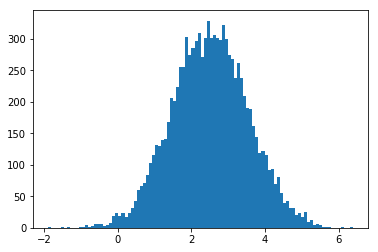

In [33]:
plt.hist(res,100)